In [ ]:
import tensorflow as tf
import numpy as np
import random
import os
import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
!nvidia-smi

Fri Nov 19 17:55:22 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   54C    P8    30W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Google Colab offers free GPUs. However, not all of them are compatible for mixed precision training. So we need a *Tesla T4 GPU* to train our models with mixed precision.

In [ ]:
!nvidia-smi -L

GPU 0: Tesla K80 (UUID: GPU-56cae7ca-9c3c-3f73-a1e6-cc58ca5289b8)


In [ ]:
#Get the helper functions through the raw code link
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2021-11-19 19:15:16--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py.1’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2021-11-19 19:15:17 (70.5 MB/s) - ‘helper_functions.py.1’ saved [10246/10246]



In [ ]:
from helper_functions import create_tensorboard_callback, plot_loss_curves, compare_historys

In [ ]:
#Get Tensorflow datasets to download Food Vision dataset
import tensorflow_datasets as tfds

In [ ]:
#List all available datasets
datasets_list = tfds.list_builders()
print ('food101' in datasets_list)

True


In [ ]:
#Load in the dataset
(train_data, test_data), ds_info = tfds.load(name='food101',
                                             split=['train', 'validation'],
                                             shuffle_files=True,
                                             as_supervised=True,
                                             with_info=True)

In [ ]:
#Features of food101 from TFDS
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=101),
})

In [ ]:
#Get the class names
class_names = ds_info.features['label'].names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

Now we've downloaded the Food101 dataset from TensorFlow Datasets, how about we do what any good data explorer should?

In other words, "visualize, visualize, visualize".

Let's find out a few details about our dataset:

* The shape of our input data (image tensors)
* The datatype of our input data
* What the labels of our input data look like (e.g. one-hot encoded versus label-encoded)
* Do the labels match up with the class names?

In [ ]:
#lets take one sample out of the dataset
train_one_sample = train_data.take(1)
train_one_sample

<TakeDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>


  Image Shape : (512, 512, 3)
  Image datatype : <dtype: 'uint8'>
  Target class from Food101 (tensor form) : 56
  Class name : huevos_rancheros
  Image : 
  AxesImage(54,36;334.8x217.44)(-0.5, 511.5, 511.5, -0.5)
  


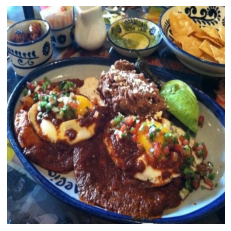

In [ ]:
#Output info about our training sample
for image, label in train_one_sample:
  print (f"""
  Image Shape : {image.shape}
  Image datatype : {image.dtype}
  Target class from Food101 (tensor form) : {label}
  Class name : {class_names[label.numpy()]}
  Image : 
  {plt.imshow(image)}{plt.axis(False)}
  """)

In [ ]:
#Creating a pre-processing function to get our data ready for modelling

def preprocess_data(image, label, img_shape=224):
  image = tf.image.resize(image, size=[img_shape, img_shape])
  return tf.cast(image, dtype=tf.float32), label

In [ ]:
preprocessed_image = preprocess_data(image, label)[0]
print (f'Image before preprocessing:\n {image[:2]}..., \nShape: {image.shape},\nDataType: {image.dtype}')
print (f'Image after preprocessing:\n {preprocessed_image[:2]}..., \nShape: {preprocessed_image.shape},\nDataType: {preprocessed_image.dtype}')

Image before preprocessing:
 [[[233 253 251]
  [231 253 250]
  [228 254 251]
  ...
  [ 85  82  89]
  [ 68  67  75]
  [ 57  57  67]]

 [[232 254 252]
  [229 254 251]
  [226 255 251]
  ...
  [121 116 120]
  [100  99 104]
  [ 86  85  91]]]..., 
Shape: (512, 512, 3),
DataType: <dtype: 'uint8'>
Image after preprocessing:
 [[[230.65816  253.64285  251.      ]
  [222.99998  254.97449  252.19388 ]
  [207.06633  255.       250.36734 ]
  ...
  [140.66287  129.52519  121.22428 ]
  [121.14268  115.265144 116.95397 ]
  [ 83.95363   83.08119   89.63737 ]]

 [[221.47449  254.37755  253.33163 ]
  [214.5102   255.       253.92348 ]
  [198.41327  254.58673  251.96939 ]
  ...
  [208.66318  195.82143  173.40823 ]
  [197.03056  190.1071   174.83162 ]
  [175.54036  171.6169   161.21384 ]]]..., 
Shape: (224, 224, 3),
DataType: <dtype: 'float32'>


###We are going to batch and prepare datasets and parallelize it

In [ ]:
#Paralleliing a function
train_data = train_data.map(map_func=preprocess_data, num_parallel_calls=tf.data.AUTOTUNE)
#Shuffle train data and turn it into batches
train_data = train_data.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE) #buffer size denotes the number of images to shuffle at a time

#Paralleliing a function
test_data = test_data.map(map_func=preprocess_data, num_parallel_calls=tf.data.AUTOTUNE).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)
#buffer size denotes the number of images to shuffle at a time

In [ ]:
train_data, test_data

(<PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int64)>,
 <PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int64)>)

In [ ]:
#Now lets create some callbacks (TensorBoard and ModelCheckpoint callback)

path = 'model_checkpoints/cp.ckpt'
createModelCheckpointCallback = tf.keras.callbacks.ModelCheckpoint(filepath=path,
                                                                   monitor='val_acc',
                                                                   save_best_only=True,
                                                                   save_weights_only=True,
                                                                   verbose=0)

Time to set up mixed precision training

In [ ]:
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy("mixed_float16")

Now lets build our feature extraction model

In [ ]:
#create a base model
input_shape=(224,224,3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

#Create functional model
inputs = tf.keras.layers.Input(shape=input_shape, name='input_layer')
x = base_model(inputs, training=False)#make sure layers are frozen
x = tf.keras.layers.GlobalAvgPool2D()(x)
x = tf.keras.layers.Dense(len(class_names))(x)
#The following is the change for mixed precision (for us to change the dtype to float32)
outputs = tf.keras.layers.Activation(activation='softmax', dtype=tf.float32, name='softmax_float32')(x)
model = tf.keras.Model(inputs, outputs)

In [ ]:
#Lets compile the model now (Use sparseCategoricalCrossentropy as loss since labels are not one-hot-encoded)
model.compile(loss=tf.keras.losses.sparse_categorical_crossentropy,
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling2d_2   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_2 (Dense)             (None, 101)               129381    
                                                                 
 softmax_float32 (Activation  (None, 101)              0         
 )                                                               
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-train

Check what datatype what each of the layers are in (are we using mixed precision)


In [ ]:
for layer in model.layers:
  print (layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_layer True float32 <Policy "float32">
efficientnetb0 False float32 <Policy "mixed_float16">
global_average_pooling2d_2 True float32 <Policy "mixed_float16">
dense_2 True float32 <Policy "mixed_float16">
softmax_float32 True float32 <Policy "float32">


In [ ]:
history_0 = model.fit(train_data,
                      epochs=3,
                      steps_per_epoch=len(train_data),
                      validation_data = test_data,
                      validation_steps = int(0.15*len(test_data)),
                      callbacks = [create_tensorboard_callback(dir_name="training_logs",
                                                               experiment_name="effecientNetB0"),
                                   createModelCheckpointCallback])

Saving TensorBoard log files to: training_logs/effecientNetB0/20211119-191715
Epoch 1/3


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


2368/2368 [==============================] - ETA: 0s - loss: 1.8223 - accuracy: 0.5587WARNING:tensorflow:Can save best model only with val_acc available, skipping.


2368/2368 [==============================] - 314s 113ms/step - loss: 1.8223 - accuracy: 0.5587 - val_loss: 1.2434 - val_accuracy: 0.6735
Epoch 2/3
2367/2368 [============================>.] - ETA: 0s - loss: 1.2929 - accuracy: 0.6676WARNING:tensorflow:Can save best model only with val_acc available, skipping.


2368/2368 [==============================] - 251s 105ms/step - loss: 1.2929 - accuracy: 0.6676 - val_loss: 1.1337 - val_accuracy: 0.6962
Epoch 3/3
2367/2368 [============================>.] - ETA: 0s - loss: 1.1442 - accuracy: 0.7016WARNING:tensorflow:Can save best model only with val_acc available, skipping.


2368/2368 [==============================] - 251s 105ms/step - loss: 1.1443 - accuracy: 0.7016 - val_loss: 1.0906 - val_accuracy: 0.7037


In [ ]:
evaluation_resuls = model.evaluate(test_data)

790/790 [==============================] - 83s 105ms/step - loss: 1.0922 - accuracy: 0.7048
